In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.path.append("/home/ecbm4040/Final_Project/e4040-2021Fall-Project-SCNN-as6430-as6456-vsk2123/src/")

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# CIFAR10 Dataset
from modules.utils import load_data
X_train, y_train,X_test,y_test = load_data(mode='all')
num_training = 49000
num_validation = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image

X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_val = X_val.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_test = X_test.reshape(-1,3,32,32).transpose(0,2,3,1) / 255

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
y_test_dummy = tf.keras.utils.to_categorical(y_test)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)
print('Test labels shape (one-hot): ', y_test_dummy.shape)

./data/cifar-10-python.tar.gz already exists. Begin extracting...
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Train labels shape (one-hot):  (49000, 10)
Validation labels shape (one-hot):  (1000, 10)
Test labels shape (one-hot):  (10000, 10)


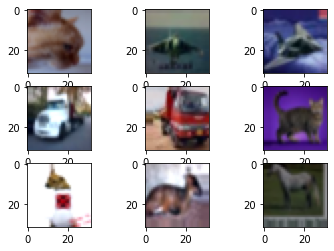

In [6]:
# Data augmentation code
import numpy as np
import random

def HSV_perturbations(image):
    choice=random.randint(1,3)
    print(choice)
    image = np.array(image)
    if choice ==1:
        return tf.image.random_hue(image, 1/random.randint(1,10))
    elif choice ==2:
        return tf.image.random_saturation(image, 5, 10)
    else:
        return image # so as to avoid not change hue for every image

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
    )
datagen.fit(X_train)

# Plot sample augmented images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

### CNN Structure as described  in paperm
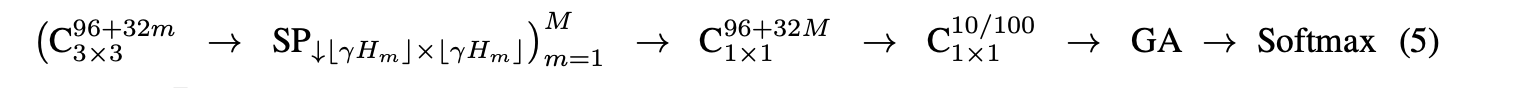

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras import Model

In [10]:
from modules.CNN_withSpectralPooling import build_spectral_conv_model_3x3

In [11]:
SpectralPooling_3x3_SpectralConvolutionModel = build_spectral_conv_model_3x3(X_train.shape[1:],M=8,num_output=10,gamma=0.85)

Building Conv layer 1 with Filters count 128 and cnn_kernel_size (3, 3)
Building Conv layer 2 with Filters count 160 and cnn_kernel_size (3, 3)
Building Conv layer 3 with Filters count 192 and cnn_kernel_size (3, 3)
Building Conv layer 4 with Filters count 224 and cnn_kernel_size (3, 3)
Building Conv layer 5 with Filters count 256 and cnn_kernel_size (3, 3)
Building Conv layer 6 with Filters count 288 and cnn_kernel_size (3, 3)
Building Conv layer 7 with Filters count 320 and cnn_kernel_size (3, 3)
Building Conv layer penultimate  with Filters count 352 and cnn_kernel_size (1, 1)
Building Conv layer penultimate  with Filters count 10 and cnn_kernel_size (1, 1)


In [14]:
batch_size=128
nb_epochs=50

output_size=10

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
valid_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

print(SpectralPooling_3x3_SpectralConvolutionModel.summary())

SpectralPooling_3x3_SpectralConvolutionModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history=SpectralPooling_3x3_SpectralConvolutionModel.fit_generator(train_generator,epochs=nb_epochs,steps_per_epoch=len(X_train)//batch_size, validation_data=valid_generator)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_conv2d (spectralCon (None, None, None, 128)   3584      
_________________________________________________________________
spectral__pool (Spectral_Poo multiple                  0         
_________________________________________________________________
re_lu (ReLU)                 (128, 26, 26, 128)        0         
_________________________________________________________________
spectral_conv2d_1 (spectralC (128, 24, 24, 160)        184480    
_________________________________________________________________
spectral__pool_1 (Spectral_P (128, 20, 20, 160)        0         
_________________________________________________________________
re_lu_1 (ReLU)               (128, 20, 20, 160)        0         
_________________________________________________________________
spectral_conv2d_2 (spectralC (128, 18, 18, 192)        2

InvalidArgumentError:  Incompatible shapes: [128,1] vs. [104,10]
	 [[node gradient_tape/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/mul (defined at <ipython-input-14-b0d7103e298f>:13) ]] [Op:__inference_train_function_7090]

Function call stack:
train_function


In [ ]:
# Save the model
SpectralPooling_3x3_SpectralConvolutionModel.save('3x3Spectral_Pooling_SpectralConvolution.h5') # Save model

# Save the history so as to make the plot
import pickle
with open('history_3x3Spectral_Pooling_SpectralConvolution', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
results = SpectralPooling_3x3_SpectralConvolutionModel.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

In [ ]:
SpectralPooling_3x3_SpectralConvolutionModel.save('tensorflow/SpectralPooling_3x3_SpectralConvolutionModel')